<a href="https://colab.research.google.com/github/bessx/aniclass/blob/master/AniClass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Performance Comparison of Convolutional Neural Networks for Animal Classification on Disproportionate Datasets

by Adam Bess, Blessing Ajibero, Cheng Yan, Jacques Comeaux, Jesse Dai, Josh Duke, Mahfuza Khatun, Sweta Ghimire

Dataset downloader: https://github.com/bessx/aniclass

[(•̀ᴗ•́)و ̑̑](http://git.bess.ai/aniclass)

# Environment Setup

In [0]:
#@title Download Image Datasets

!wget -nc http://csc.lsu.edu/~bess/aniclass/test.tgz
!wget -nc http://csc.lsu.edu/~bess/aniclass/teddy.tgz
!wget -nc http://csc.lsu.edu/~bess/aniclass/train100.tgz
!wget -nc http://csc.lsu.edu/~bess/aniclass/train1000.tgz
!wget -nc http://csc.lsu.edu/~bess/aniclass/train10000.tgz

--2020-04-30 02:20:06--  http://csc.lsu.edu/~bess/aniclass/train1000.tgz
Resolving csc.lsu.edu (csc.lsu.edu)... 96.125.115.208
Connecting to csc.lsu.edu (csc.lsu.edu)|96.125.115.208|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 323890270 (309M) [application/x-gzip]
Saving to: ‘train1000.tgz’

train1000.tgz        10%[=>                  ]  32.32M  5.26MB/s    eta 66s    

In [0]:
#@title Unpack Dataset Tars

!tar xzkf test.tgz
!tar xzkf teddy.tgz
!tar xzkf train100.tgz
!tar xzkf train1000.tgz
!tar xzkf train10000.tgz

tar (child): teddy.tgz: Cannot open: No such file or directory
tar (child): Error is not recoverable: exiting now
tar: Child returned status 2
tar: Error is not recoverable: exiting now
tar (child): train1000.tgz: Cannot open: No such file or directory
tar (child): Error is not recoverable: exiting now
tar: Child returned status 2
tar: Error is not recoverable: exiting now
tar (child): train10000.tgz: Cannot open: No such file or directory
tar (child): Error is not recoverable: exiting now
tar: Child returned status 2
tar: Error is not recoverable: exiting now


In [2]:
#@title Import Commands
from keras.applications import xception, vgg16, inception_v3
# from keras.applications.resnet import ResNet101,ResNet152,ResNet50
# from keras.applications.densenet import DenseNet121,DenseNet169,DenseNet201
# from keras.applications.nasnet import NASNetMobile,NASNetLarge

#from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras.applications.inception_v3 import InceptionV3
from keras.models import Model, Sequential, clone_model, load_model
from keras import layers, utils
from keras.layers import Dense, Activation, Flatten, add
from keras.layers.pooling import GlobalAveragePooling2D
from keras.utils.np_utils import to_categorical
from keras.optimizers import SGD
from keras.callbacks import History, ModelCheckpoint

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

%matplotlib inline

Using TensorFlow backend.


# Models Setup

In [22]:
#@title Load Xception and freeze final layers
# Import Xception without bottom two layers
xcept_base = xception.Xception(include_top=False, weights='imagenet')
xcept_base.name = 'xcept_base' 

# Create two layers with 10 classes in final prediction layer
x = xcept_base.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(10, activation='softmax')(x)

# Add the top layer block to the base model
xcept_train = Model(xcept_base.input, predictions)
xcept_train.name = 'xcept'

# Freeze all but final two layers of xcept model
for ind, layer in enumerate(xcept_train.layers):
  if ind >= (len(xcept_train.layers)-2):
    layer.trainable = True
    # print(ind, layer, "if")
  else: 
    layer.trainable = False
    # print(ind, layer, "else")

83689472/83683744 [==============================] - 3s 0us/step


In [23]:
#@title Load Inception and freeze final layers

# Import Inception without bottom two layers
incept_base = inception_v3.InceptionV3(include_top=False, weights='imagenet')
incept_base.name = 'incept_base' 

# Create two layers with 10 classes in final prediction layer
y = incept_base.output
y = GlobalAveragePooling2D()(y)
predictions = Dense(10, activation='softmax')(y)

# Add the top layer block to the base model
incept_train = Model(incept_base.input, predictions)
incept_train.name = 'incept'

#@title Freeze all but final two layers of incept model
for ind, layer in enumerate(incept_train.layers):
  if ind >= (len(incept_train.layers)-2):
    layer.trainable = True
    # print(ind, layer, "if")
  else: 
    layer.trainable = False
    # print(ind, layer, "else")

87916544/87910968 [==============================] - 2s 0us/step


In [0]:
#@title Load VGG16 and freeze final layers
vgg16_base = vgg16.VGG16(include_top=True, weights='imagenet')
vgg16_base.name = 'vgg16_pre'

vgg16_input  = vgg16_base.get_layer(index=0).input
vgg16_output = vgg16_base.get_layer(index=-2).output
vgg16_model = Model(inputs=vgg16_input, outputs=vgg16_output)
vgg16_model.name = 'vgg16_base'

vgg16_train = Sequential()
vgg16_train.add(vgg16_model)
vgg16_train.add(Dense(10, activation='softmax', input_dim=4096, name='predictions'))
vgg16_train.name = 'vgg16'

# Freeze all but final two layers of VGG16 model
for ind, layer in enumerate(vgg16_train.layers):
  if ind >= (len(vgg16_train.layers)-1):
    layer.trainable = True
    # print(ind, layer, "if")
  else: 
    layer.trainable = False
    # print(ind, layer, "else")

In [0]:
# Save Models to List
model_list = [xcept_train, vgg16_train, incept_train]

# Make Models Folder
!mkdir models

# Make Results Folder
!mkdir results

# Save Models to Folder
for mdl in model_list:
  mdl.save('models/' + mdl.name + '_train.h5')
  print('Saved ' + mdl.name + '_train to disk')

# Retrain Last Layers

In [0]:
#@title Set Variables for Training: { run: "auto" }

trainmodel = incept_train #@param ["xcept_train", "incept_train", "vgg16_train"] {type:"raw"}
traindir = 'train100' #@param ["train100", "train1000", "train10000"]

img_height = 299 #@param {type:"integer"}
img_width = 299 #@param {type:"integer"}

batch_size = 50 #@param {type:"integer"}
nb_epochs = 20 #@param {type:"integer"}


# Set Save Name
sname = trainmodel.name + '_' + traindir

In [0]:
#@title Retrain final 2 layers of model { vertical-output: true }

print('Loading model ' + trainmodel.name + '...')
model = load_model('models/' + trainmodel.name + '_train.h5')

train_datagen = ImageDataGenerator(rescale=1./255,
    # shear_range=0.2,
    # zoom_range=0.2,
    # horizontal_flip=True,
    validation_split=0.15) # set validation split

train_generator = train_datagen.flow_from_directory(
    traindir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(
    traindir, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation') # set as validation data

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    'test', 
    target_size=(img_height, img_width), 
    batch_size=batch_size, 
    class_mode='binary')

# Fix for Corrupt Images
def my_gen(gen):
    while True:
        try:
            data, labels = next(gen)
            yield data, labels
        except:
            pass

# Learning rate is changed to 0.001
sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd, loss='sparse_categorical_crossentropy', metrics=['acc'])

# Save accuracy to history
filepath = 'models/' + sname + ".h5"

cblist = [
    History(),
    ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True)
]

train = model.fit_generator(
    my_gen(train_generator),
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = my_gen(validation_generator), 
    validation_steps = validation_generator.samples // batch_size,
    epochs = nb_epochs,
    callbacks=cblist)

# Print model evaluation and save to results
meval = model.evaluate_generator(test_generator, verbose=1)
mev = 'test loss: %.5f - test acc: %.2f%%' % (meval[0], meval[1]*100)
print(mev)
%store meval > models/"$sname"_eval.txt
%store mev > results/"$sname"_ev.txt

Loading model incept...


/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Found 850 images belonging to 10 classes.
Found 150 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Epoch 1/20
17/17 [==============================] - 23s 1s/step - loss: 2.3540 - acc: 0.1212 - val_loss: 2.1560 - val_acc: 0.2733

Epoch 00001: val_acc improved from -inf to 0.27333, saving model to models/incept_train100.h5
Epoch 2/20
17/17 [==============================] - 7s 418ms/step - loss: 2.1361 - acc: 0.2459 - val_loss: 1.8751 - val_acc: 0.4333

Epoch 00002: val_acc improved from 0.27333 to 0.43333, saving model to models/incept_train100.h5
Epoch 3/20
17/17 [==============================] - 7s 432ms/step - loss: 1.9260 - acc: 0.4565 - val_loss: 1.8696 - val_acc: 0.5133

Epoch 00003: val_acc improved from 0.43333 to 0.51333, saving model to models/incept_train100.h5
Epoch 4/20
17/17 [==============================] - 9s 516ms/step - loss: 1.7405 - acc: 0.5729 - val_loss: 1.5612 - val_acc: 0.6067

Epoch 00004: val_acc improved from 0.51333 to 0.60667, 

Exception ignored in: <generator object my_gen at 0x7f32b9749ba0>
RuntimeError: generator ignored GeneratorExit


 2/20 [==>...........................] - ETA: 14s

Exception ignored in: <generator object my_gen at 0x7f32bbe4d990>
RuntimeError: generator ignored GeneratorExit


20/20 [==============================] - 9s 449ms/step
test loss: 0.72662 - test acc: 78.90%
Writing 'meval' (list) to file 'models/incept_train100_eval.txt'.
Writing 'mev' (str) to file 'results/incept_train100_ev.txt'.


In [0]:
# plt.clf()
# plt.close('all')

<Figure size 432x288 with 0 Axes>

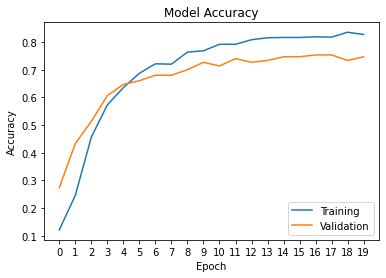

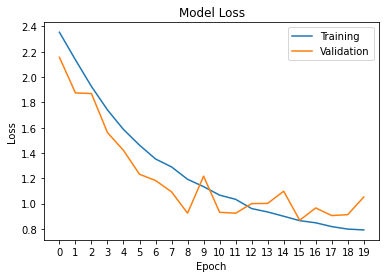

Writing 'train.history' (dict) to file 'results/incept_train100_history.txt'.
Writing 'hist_df' (DataFrame) to file 'results/incept_train100_histdf.txt'.


In [0]:
#@title Plot accuracy and loss and save results

# summarize history for accuracy
plt.plot(train.history['acc'])
plt.plot(train.history['val_acc'])
plt.title('Model Accuracy')  
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.xticks(range(0, nb_epochs))
plt.legend(['Training', 'Validation'], loc='lower right')
plt.savefig('results/' + sname + '_acc.png', bbox_inches='tight')
plt.show()

# summarize history for loss
plt.plot(train.history['loss'])
plt.plot(train.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.xticks(range(0, nb_epochs))
plt.legend(['Training', 'Validation'], loc='upper right')
plt.savefig('results/' + sname + '_loss.png', bbox_inches='tight')
plt.show()

# build history dataframe and save
hist_df = pd.DataFrame(train.history)
%store train.history > results/"$sname"_history.txt
%store hist_df > results/"$sname"_histdf.txt

In [0]:
hist_df

,val_loss,val_acc,loss,acc
0,1.699004,0.528000,1.954387,0.391875
1,1.588994,0.527660,1.605360,0.529712
2,1.472056,0.621277,1.489801,0.537380
3,1.184747,0.617021,1.334899,0.592971
4,1.309450,0.693617,1.288112,0.617252
5,1.303739,0.706383,1.149035,0.683067
6,1.156175,0.724000,1.110734,0.695847
7,1.159007,0.736170,1.026815,0.717572
8,1.109099,0.774468,0.962062,0.752716
9,0.969011,0.770213,0.937974,0.743131


In [0]:
#@title Predictions with current model of directory: { vertical-output: true }
pred_model = 'incept_train100' #@param ['xcept_train100','xcept_train1000','xcept_train10000', 'vgg16_train100', 'vgg16_train1000', 'vgg16_train10000','incept_train100','incept_train1000','incept_train10000']

pred_dir = 'test' #@param ['test', 'train100','train1000', 'train10000', 'teddy']


print('Loading model models/' + pred_model + '.h5...')
model = load_model('models/' + pred_model + '.h5')

pred_datagen = ImageDataGenerator(rescale=1./255)

pred_generator = test_datagen.flow_from_directory(
    pred_dir, 
    target_size=(img_height, img_width), 
    batch_size=batch_size, 
    class_mode='binary')

pred = model.predict_generator(pred_generator, pred_generator.samples // batch_size, verbose=1)

Loading model models/incept_train100.h5...
Found 1000 images belonging to 10 classes.
20/20 [==============================] - 11s 539ms/step


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


results/incept_train100_pred_test_cm.png


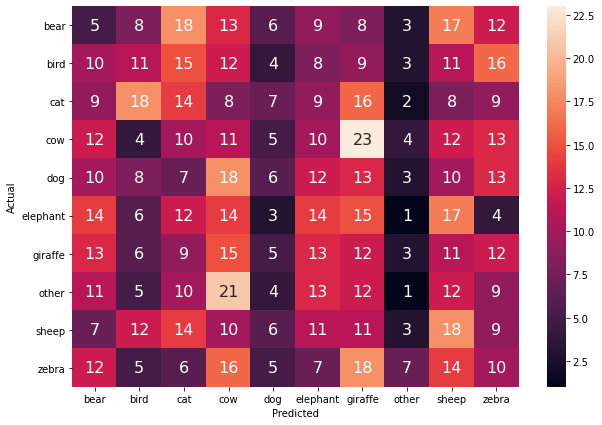

In [0]:
#@title Create Confusion Matrix from Predictions { vertical-output: true }

import seaborn as sn
from sklearn.metrics import confusion_matrix
y_true = pred_generator.classes
y_pred = np.argmax(pred, axis=-1)
cm = confusion_matrix(y_true, y_pred)

labels = ['bear', 'bird','cat', 'cow', 'dog', 'elephant', 'giraffe', 'other', 
          'sheep', 'zebra']

df_cm = pd.DataFrame(cm, index = [i for i in labels],
                  columns = [i for i in labels])
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16})
# sn.set(font_scale=1.4)
plt.savefig('results/'+ pred_model + '_pred_' + pred_dir + '_cm.png', bbox_inches='tight')
print('results/'+ pred_model + '_pred_' + pred_dir + '_cm.png')
plt.show()

In [0]:
#@title Predictions as Pandas Dataframe

pred_files = pred_generator.filenames
pred_df = pd.DataFrame(pred)
pred_df.columns = ['bear', 'bird','cat', 'cow', 'dog', 'elephant', 'giraffe', 'other', 'sheep', 'zebra']

# [i.split('\t', 1)[0] for i in l]
pred_df['file'] = pred_files
pred_df.insert(0, 'class', [item.split('/')[0] for item in pred_files])
pred_df

# Average of predicted class by actual class
class_preds = pred_df.groupby('class').mean().round(5).astype(object)*100
class_preds


,bear,bird,cat,cow,dog,elephant,giraffe,other,sheep,zebra
class,,,,,,,,,,
other,1.371,2.17,2.94,1.013,2.92,0.589,0.756,86.667,1.139,0.435


In [0]:
%store pred_df > results/"$pred_model"_teddy_all.txt
%store class_preds > results/"$pred_model"_teddy.txt

Writing 'pred_df' (DataFrame) to file 'results/xcept_train10000_teddy_all.txt'.
Writing 'class_preds' (DataFrame) to file 'results/xcept_train10000_teddy.txt'.


# Results File Download

In [0]:
#@title Save results to csc server:
#@markdown http://csc.lsu.edu/~bess/aniclass/results

!rm results.tgz
!tar czvf results.tgz results/
from google.colab import files
files.download('results.tgz')

results/
results/xcept_train10000_loss.png
results/xcept_train100_pred_train100_cm.png
results/xcept_train100_acc.png
results/xcept_train1000_teddy.txt
results/xcept_train100_loss.png
results/xcept_train1000_pred_train1000_cm.png
results/xcept_train1000_pred_test_cm.png
results/xcept_train100_histdf.txt
results/xcept_train100_teddy_all.txt
results/xcept_train1000_histdf.txt
results/xcept_train10000_pred_train1000_cm.png
results/xcept_train10000_pred_train10000_cm.png
results/xcept_train1000_history.txt
results/xcept_train10000_pred_test_cm.png
results/xcept_train1000_pred_train10000_cm.png
results/xcept_train10000_pred_train100_cm.png
results/.ipynb_checkpoints/
results/xcept_train100_pred_test_cm.png
results/xcept_train10000_ev.txt
results/xcept_train1000_pred_train100_cm.png
results/xcept_train1000_teddy_all.txt
results/xcept_train1000_loss.png
results/xcept_train100_history.txt
results/xcept_train1000_ev.txt
results/xcept_train10000_acc.png
results/xcept_train10000_teddy_all.txt
res

# The following code is for individual image and model tests

In [0]:
# Get Test Images
!wget -nc -q -P example_images/ https://upload.wikimedia.org/wikipedia/commons/f/f9/Zoorashia_elephant.jpg
!wget -nc -q http://farm1.static.flickr.com/145/430300483_21e993670c.jpg -O example_images/eagle.jpg

In [0]:
# Test Images Individually

# load an image from file
image = load_img('example_images/eagle.jpg', target_size=(224, 224))
image = img_to_array(image)

# reshape data for the model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

# prepare the image for the VGG model
image = preprocess_input(image)
features = vgg16_pre.predict(image)

# Print Predictions
print('Predictions:')
preds = decode_predictions(features, top=5)[0]
for p in preds:
  print('%s: %s (%.2f%%)' % (p[0], p[1], p[2]*100))

In [0]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off')

In [0]:
import pathlib

# data_dir = utils.get_file(origin='https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',fname='flower_photos', untar=True)

data_dir = pathlib.Path('ImageNetOther/')

image_count = len(list(data_dir.glob('*/*.jpg')))
image_count

CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"])
CLASS_NAMES

image_generator = ImageDataGenerator(rescale=1./255)

BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)

train_data_gen = image_generator.flow_from_directory(directory=str(data_dir),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(CLASS_NAMES))

test_generator = image_generator.flow_from_directory(directory=str(data_dir),
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=1,
    class_mode=None,
    shuffle=False,
    seed=42
)

# test_gen = datagen.flow_from_directory('/content/drive/My Drive/CSC7333/test/', target_size=(224,224), class_mode='binary')
# test_samples = len(test_gen.filenames)

Found 100 images belonging to 1 classes.
Found 100 images belonging to 1 classes.


In [0]:
image_batch, label_batch = next(train_data_gen)
show_batch(image_batch, label_batch)

In [0]:
print(test_generator.filenames[82])
print(test_generator.filenames[83])

In [0]:
STEP_SIZE_TEST = test_generator.n//test_generator.batch_size

test_generator.reset()

pred = ovgg16.predict_generator(test_generator, steps=STEP_SIZE_TEST, verbose=1)

# predicted_class_indices=np.argmax(pred,axis=1)

In [0]:
predicted_class_indices=np.argmax(pred,axis=1)
print(predicted_class_indices)

In [0]:
# Print Predictions
print('Predictions:')
preds = decode_predictions(pred, top=5)[0]
for p in preds:
  print('%s: %s (%.2f%%)' % (p[0], p[1], p[2]*100))